In [1]:
# correlation matrix
# correlation magnitude by neuron type

In [26]:
from drn_interactions.load import load_derived_generic
from drn_interactions.spikes import SpikesHandler, SpikesHandlerMulti

from drn_interactions.spikes import SpikesHandler
from drn_interactions.load import load_derived_generic, get_fig_dir
from binit.bin import which_bin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances


import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from drn_interactions.transforms import bin_spikes
from spiketimes.df.surrogates import shuffled_isi_spiketrains_by
from scipy.stats import zscore

from sklearn.preprocessing import minmax_scale
import networkx as nx
import node2vec


In [28]:
def rectify(arr):
    return np.where(arr < 0, 0, arr)

def zero_diag(X):
    np.fill_diagonal(X, 0)
    return X

def pairwise_cosine(df):
    A = 1 - pairwise_distances(df.transpose(), metric="cosine")
    A = zero_diag(A)
    out = pd.DataFrame(A, columns=df.columns, index=df.columns)
    return out

def pairwise_corr(df, set_zero_diag=True, adjust=None):
    corr = df.corr().fillna(0)

    if adjust is not None:
        if adjust == "shift":
            corr = corr + 1
        elif adjust == "rectify":
            corr = corr.apply(rectify)
        else:
            raise ValueError("Unknown Adjustment")
    if set_zero_diag:
        corr = zero_diag(corr.values)
    out = pd.DataFrame(corr, columns=df.columns, index=df.columns)
    return out

def df_to_graph(df):
    return nx.from_pandas_adjacency(df)


def plot_corrmat(df, cmap="Greys", vmin=0, vmax=1, yticklabels=(), xticklabels=(), cbar=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    return sns.heatmap(df, cmap=cmap, vmin=vmin, vmax=vmax, yticklabels=yticklabels, xticklabels=xticklabels, cbar=cbar, ax=ax) 



outdir = get_fig_dir() / "interactions"
outdir.mkdir(exist_ok=True)

In [29]:
neurons = (
    load_derived_generic("clusters.csv")
    .merge(load_derived_generic("burst_features.csv"))
    [["neuron_id", "session_name", "wf_3"]]
)
sessions = neurons.session_name.unique()

In [30]:
sh = SpikesHandler(
    block="pre",
    bin_width=1,
    session_names=[sessions[1]],
    t_start=0,
    t_stop=1800,
)

In [34]:
df = pairwise_corr(sh.binned_piv, adjust="shift")
G = df_to_graph(df)

In [50]:
mod = node2vec.Node2Vec(G, dimensions=4).fit()

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 10.10it/s]


In [51]:
emb_df = (
    pd.DataFrame(
        [mod.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

<AxesSubplot:>

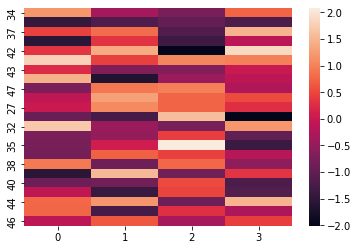

In [53]:
sns.heatmap(emb_df.apply(zscore))

In [185]:
def corr_stability(sessions, bin_width=1, t_start=0, t_stop=1800, block="pre", corr_bin_width=120):
    frames = []
    for session in sessions:
        sh = SpikesHandler(
            block=block,
            bin_width=bin_width,
            session_names=[session],
            t_start=t_start,
            t_stop=t_stop,
        )
        df = sh.binned_piv.astype(float)
        out = {}
        starts = np.arange(t_start, t_stop+1, corr_bin_width)
        first_corr = pairwise_corr(df.loc[lambda x: (x.index > starts[0]) & (x.index < starts[1])])
        for start, stop in zip(starts[1:], starts[2:]):
            corr = pairwise_corr(df.loc[lambda x: (x.index > start) & (x.index < stop)])
            out[start] = corrDist(first_corr, corr)

        frames.append(pd.DataFrame(out, index=[0]).assign(session_name = session))
    return pd.concat(frames).reset_index(drop=True)


def corr_stability_multi(sessions, bin_width=1, t_start=0, t_stop=1800, block="pre", corr_bin_width=120):
    frames = []
    for session in sessions:
        sh = SpikesHandlerMulti(
            block=block,
            bin_width=bin_width,
            session_names=[session],
            t_start=t_start,
            t_stop=t_stop,
        )
        df = sh.binned_piv.astype(float)
        out = {}
        starts = np.arange(t_start, t_stop+1, corr_bin_width)
        first_corr = pairwise_corr(df.loc[lambda x: (x.index > starts[0]) & (x.index < starts[1])])
        for start, stop in zip(starts[1:], starts[2:]):
            corr = pairwise_corr(df.loc[lambda x: (x.index > start) & (x.index < stop)])
            out[start] = corrDist(first_corr, corr)

        frames.append(pd.DataFrame(out, index=[0]).assign(session_name = session))
    return pd.concat(frames).reset_index(drop=True)

In [179]:
corr = corr_stability(sessions)

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


<AxesSubplot:xlabel='variable', ylabel='value'>

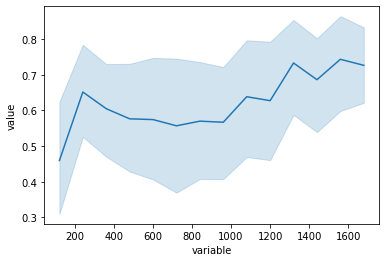

In [180]:
df = corr.melt(id_vars="session_name").dropna()
sns.lineplot(data=df, x="variable", y="value")

In [181]:
from drn_interactions.load import load_events

In [182]:
sessions = load_events("base_shock")["session_name"].unique()

In [192]:
corr = corr_stability_multi(
    sessions, 
    t_start=-600, 
    t_stop=1200,  
    block=["base_shock", "post_base_shock"], 
    corr_bin_width=60
    )
df = corr.melt(id_vars="session_name").dropna()
sns.lineplot(data=df, x="variable", y="value")

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


<AxesSubplot:xlabel='variable', ylabel='value'>

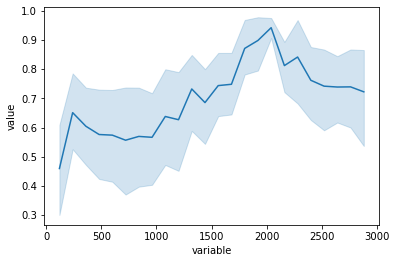

In [195]:
corr = corr_stability_multi(
    sessions, 
    t_start=000, 
    t_stop=3000,  
    block=[ "pre", "base_shock", "post_base_shock"], 
    corr_bin_width=120
    )
df = corr.melt(id_vars="session_name").dropna()
sns.lineplot(data=df, x="variable", y="value")

In [ ]:
corr = pairwise_corr(df)
ax = plot_corrmat(corr)
ax.axis("off")
# plt.savefig(outdir / "example corr.png", dpi=300)